## GOES introduction ##
In this exercise, you will 
* Obtain GOES ABI data from a NOAA repository on AWS
* Examine the contents of a GOES data file
* Display GOES reflectance data
* Create true-color images from reflectance
* Construct and interpret NDVI
* Use a cloud mask to isolate cloudy and cloud-free parts of the ABI images

### Before you begin!! 
Copy this file and met4450.py to your home directory on jetstream-cloud.org so that your work is not overwritten when the server restarts and so you can refer back to the original version if needed.

In [ ]:
# Import the packages that we will use
import hvplot.xarray
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    import met4450
except ImportError:
    print('Uh oh!!')
    print('You must have met4450.py in the same directory as this file or somewhere else in your python path')

In [ ]:
# Connect to Amazon Web Services public datastores
import s3fs
fs = s3fs.S3FileSystem(anon=True)

## Find and open a file of GOES data

The function `find_goes_filename` within the `met4450` package makes it easy to find GOES data on AWS. The keyword arguments are
* `satellite` - defines which GOES satellite to use. Possible values are
   * `16, '16', 'G16', 'GOES16', 'GOES-16', 'GOES-EAST', 'EAST'` for GOES-16
   * `17, '17', 'G17', 'GOES17', 'GOES-17'` for GOES-17
   * `18, '18', 'G18', 'GOES18', 'GOES-18', 'GOES-WEST', 'WEST'` for GOES-18
* `product` - defines which ABI product to use. Typically use `'ABI-L2-MCMIP'`, which is the cloud and moisture imagery for all bands in one file, all at the same resolution (2 km). See [link](https://github.com/awslabs/open-data-docs/tree/main/docs/noaa/noaa-goes16) for a full list of GOES-16, 17, 18 products.
* `domain` - defines the ABI field of view. Possible values are 
    * `'F'` for Full disk
    * `'C'` for CONUS
    * `'M1'` or `'M2'` for Mesoscale sector 1 or 2
* `datetime` - defines the date and time of interest. Data for the nearest matching time will be returned. Use the format `'YYYY-MM-DD HH:MM'`. (Timestamp and datetime objects are also OK, if you know what they are.) The datetime must be *after* the following operational start dates
    * 2017-03-01 for GOES-16
    * 2018-08-29 for GOES-17
    * 2022-07-28 for GOES-18
    
The function will return the path to the data nearest in time to the datetime that you provide.

#### DO...
1. Read and run the following cell. Later you will come back and modify it.

In [ ]:
# Find file for a date, time, product and domain of intrest
fileinfo = met4450.find_goes_dataset(satellite=16,
                        product='ABI-L2-MCMIP',
                        domain='C',
                        datetime='2024-02-26 19:00')

# Print the name of the file that we will read
print( 'Reading file: https://{:s}.s3.amazonaws.com/{:s}'.format( *fileinfo.file[0].split('/',1) ) )
                                           
# Load the data from AWS
goes = xr.open_dataset( fs.open( fileinfo.file[0] ) )

## Read metadata from a GOES file to understand its contents
The variable `goes` (defined in the above cell) is a dataset that contains all contents of the netCDF file. The dataset contains many variables within it. For example, `goes['x']` is the variable that contains the x coordinate of the data and `goes['y']` is the y coordinate variable. Imagery from the 16 ABI bands are contained in the variables `CMI_Cxx`, where xx is a number 01-16, so `goes['CMI_C01']` is the variable containing data from ABI band 1. See this [link](https://www.goes-r.gov/spacesegment/ABI-tech-summary.html) for a summary of the wavelengths corresponding to each band.

#### DO...
1. Explore the variables in the dataset after running the next cell.
2. Click the triangle by "Coordinates" and the paper icon for the "x" coordinate.
3. Click the triangle by "Data variables" and the paper icon for the "CMI_C01" variable.
4. Answer the question below.

*Turn in:* Answer the following questions
1. What are the size of the `x` and `y` dimensions of the data?
2. What are the units for `x` and `y`?
3. What is the "long_name" for the variable `CMI_C01`?
4. What are the units for the variable `CMI_C01`?

In [ ]:
# Display summary of dataset
# Explore the output
goes

## Display GOES data

We are ready to visualize some data now.

#### DO...
1. Run the next two cells and explore the images.
2. Appreciate how cool it is that *you* can image the Earth as it was any time since GOES-16 launched until as recently as 5 minutes ago! 
3. Hover your cursor over Lake Okeechobee in the 2nd cell below and read the reflectance factor. Test some other surfaces.

*Turn in:*
1. What the reflectance factors for Lake Okeechobee and the Gulf of Mexico? (Report your answer to 1 significant digit) 
2. Why is the reflectance factor different for the two water surfaces? 

In [ ]:
# Display band 3 (0.86µm) reflectance
goes['CMI_C03'].plot.imshow()

In [ ]:
# Repeat as an interactive plot
goes['CMI_C03'].hvplot('x','y',data_aspect=1)

## Explore ##

#### DO...
1. Go back to the top of this program and change the datetime to '2023-08-30 23:00', domain to 'M1' (mesoscale), and display channel. What do you find?
2. Experiment with the commands above to change the ABI band, date and time, domain, or a different GOES satellite. 

## True color images ##
To create a true color image (aka natural color), we must define the brightness of red, blue, and green components. ABI has blue (band 1) and red (band 2) bands. We will treat band 3 (0.86 µm) as green because, as we have seen, green vegetation also reflects near IR light.

#### Do...
1. Read the next two cells to understand what they are doing.
2. Run the next two cells.

In [ ]:
# Define red, blue, and green colors for a natural color image
goes['R'] = goes['CMI_C02']
goes['G'] = goes['CMI_C03']
goes['B'] = goes['CMI_C01']

# Combine RGB into one data array
goes['RGB'] = goes[['R','G','B']].to_array()

# Restrict to range [0,1]
goes['RGB'] = np.clip( goes['RGB'], 0, 1 )

In [ ]:
# Display the natural color image
# Either of these work but hvplot looks nicer
# goes['RGB'].plot.imshow()
goes['RGB'].hvplot.rgb('x','y',bands='variable',data_aspect=1)

# You can save the figure using the buttons in the image


### Gamma correction ###

The image above probably looks very dark, except for the bright clouds. Human vision, unlike camera sensors, has a quasi-logarithmic perception of brightness, giving additional sensitivity to dark scenes. We can mimic human perception by brightening the middle-dark colors and reducing the brightness difference between clouds and other elements of the scene. "Gamma correction" is a common way to do this. A gamma correction for the red channel is defined as $$R_{new} = R^{1/\gamma}.$$ $\gamma = 2.2$ is a common choice. The process is repeated for the green and blue channels, using the same gamma value for all channels.

#### Do...
In the next cell, do the following.
1. Add a command or commands to apply a gamma correction to each of the colors (R, G, and B).
2. Add a command to display the corrected image.

*Turn in:*
1. Your image after applying the gamma correction.

In [ ]:
# Apply a gamma correction here and display the image again


### A better green ###

After applying the gamma correction, the image probably looks unrealistically bright green over almost all land areas. That's because we are using GOES band 3 (0.86 µm) as the green channel because ABI doesn't have a true green band. As we saw in chapter 5, vegetation is much more reflective in NIR than in visible green. 

The figure below shows the spectral reflectance of vegetation and other surfaces in relation to the wavelength of GEOS ABI bands. 
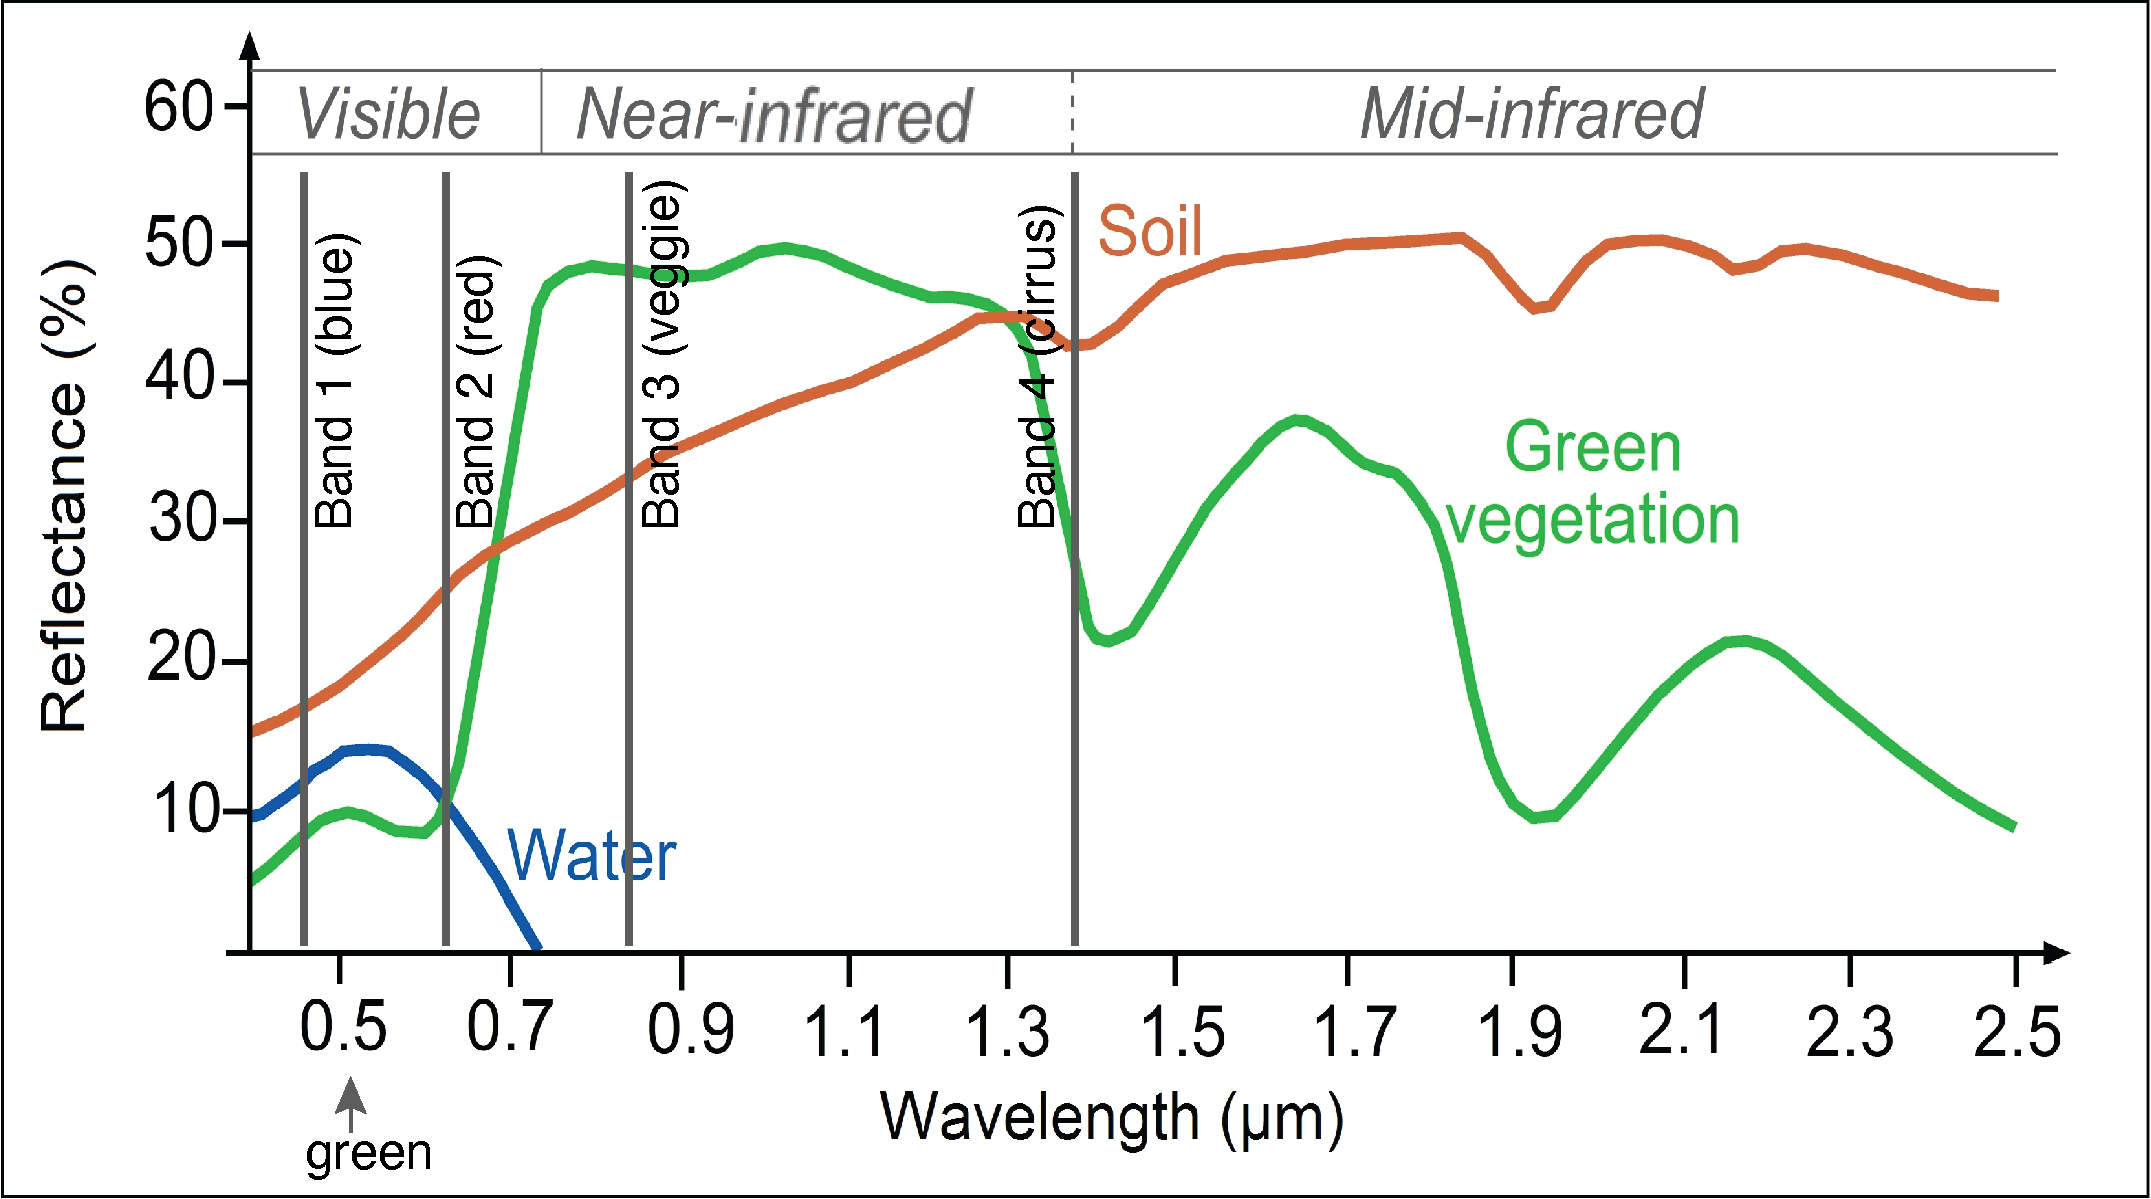

NOAA scientists have found that a weighted mixture of band 3 with bands 1 and 2 provides a better approximation of green perceived by humans than band 3 alone. One recommended mixture is 
$$G = 0.45 * band1 + 0.45 * band2 + 0.1 * band3$$


#### Do...
In the next cell, do the following.
1. Add a command starting with `goes['Gnew'] = ` to create a new green channel, based on the equation above.
2. Add commands to combine `R`, `Gnew`, and `B` into a new image, as done in earlier cells and apply the gamma correction.
3. Add a command to display your improved image.

*Turn in:*
1. Your image with the new green channel.

In [ ]:
# Redefine the green chanel and display the image again


## NDVI ##

The normalized difference vegetation index (NDVI) is a common indicator of healthy green vegetation. 
$$NDVI = \frac{NIR - Red}{NIR + Red}$$
For ABI, use band3 for NIR and band2 for Red. NDVI is relatively insensitive to the solar elevation angle and satellite viewing angle, unlike the intensities or reflectance of individual bands. NDVI values are generally negative for water, snow and clouds; 0-0.2 for bare soil, urban areas, and sparse vegtation; and 0.3-1 for vegetation, with higher values indicating denser foliage.

Look back at the image of vegetation reflectance above and talk with someone next to you about why NDVI can discriminate between vegetation, soil, and water.

#### Do...
1. In the cell below, complete the definition of `goes['NDVI']` based on the equation above.
2. Run the cell.

*Turn in:*
1. Turn in your NDVI image.
2. What land regions have highest NDVI? Lowest NDVI?

In [ ]:
# Define NDVI here, then display it. Here's a snippet to get started
goes['NDVI'] = # Fill in what goes here. (An error will be generated until you fix it.)

# Display your NDVI image, setting the colormap range to (0-1)
goes['NDVI'].hvplot('x','y',data_aspect=1,clim=(0,1))


### Seasonal changes in NDVI ###
After you have a working NDVI image, try a date from a different season. Look for differences in NDVI (ignoring changes in where the clouds appear).

# Remaining sections are optional

## Cloud masking

NDVI is intended for analysis of surface characteristics. Clouds have low or negative NDVI and it can be difficult to distinguish clouds from bare or snow-covered ground using NDVI alone. Next, we will mask out the cloud areas, so that NDVI is shown only for surface areas.

In [ ]:
# Find the cloud mask for the same time and domain as the data above
maskfileinfo = met4450.find_goes_dataset(satellite=fileinfo.attrs['satellite'],
                                        product='ABI-L2-ACM', # This is the cloud mask product
                                        domain=fileinfo.attrs['domain'],
                                        datetime=fileinfo.attrs['datetime'])
# Read the cloud mask
mask = xr.open_dataset( fs.open( maskfileinfo.file[0] ) )

# Add the cloud mask variable to our GOES dataset
# The variable is named BCM for binary cloud mask: 0=cloud free, 1=some cloud
goes['CloudMask'] = mask['BCM']
# Define a clear mask where 1=cloud free, 0=some cloud
goes['ClearMask'] = 1 - goes['CloudMask']

In [ ]:
# Display only cloud-free locations (i.e. ClearMask==1 or CloudMask==0)
goes['CMI_C03'].where( (mask['BCM']==0).values ).\
    hvplot('x','y',data_aspect=1)

In [ ]:
# Write code to display your NDVI showing only cloud-free regions


In [ ]:
# We can also apply cloud masking for RGB images. Here are two different ways to do it.
goes['RGB'].where( goes['ClearMask'] ).plot.imshow()

In [ ]:
# We can also add an alpha (transparency) layer to RGB images so that only cloud-free areas are shown
goes['RGBA'] = goes[['R','G','B','ClearMask']].to_array(dim='color')
goes['RGBA'] = np.clip( goes['RGBA'], 0, 1 )
goes['RGBA'] = goes['RGBA'] ** (1/2.2)

goes['RGBA'].plot.imshow()